# AIEM vs NMM3D Look-Up Table

This notebook mirrors the MATLAB benchmarking workflow for the Advanced Integral
Equation Model (AIEM). It loads the NMM3D 40° NRCS look-up table, evaluates the
translated AIEM implementation for the same rough-surface parameter combinations,
and quantifies agreement with the reference values across correlation-length ratios
(ℓ/σ).

The LUT provides results for exponential surface autocorrelation, so the AIEM runs with SURFACE_TYPE='exp'.


In [1]:
import os
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ssrt.surface.aiem import AIEM
from ssrt.utils.util import toLambda

NOTEBOOK_ROOT = Path.cwd().resolve()
DATA_DIR = NOTEBOOK_ROOT / 'data'
if not DATA_DIR.exists():
    DATA_DIR = NOTEBOOK_ROOT.parent / 'data'

MPL_CACHE = NOTEBOOK_ROOT / '.mpl-cache'
MPL_CACHE.mkdir(exist_ok=True)
os.environ.setdefault('MPLCONFIGDIR', str(MPL_CACHE))

LUT_PATH = DATA_DIR / 'NMM3D_LUT_NRCS_40degree.dat'
if not LUT_PATH.exists():
    raise FileNotFoundError('NMM3D LUT not found at {}'.format(LUT_PATH))

FREQUENCY_GHZ = 5.405
INCIDENCE_DEG = 40.0
SCATTER_AZIMUTH = 180.0
TARGET_RATIOS = [4, 7, 10, 15]  # [] for all ratios, or provide specific values
SURFACE_TYPE = 'exp'  # NMM3D LUT corresponds to exponential ACF
MARKERS = {i: marker for i, marker in enumerate(['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h', 'x'])}
plt.style.use('seaborn-v0_8-whitegrid')


In [2]:
import numpy as np
import math
import cmath
from typing import Dict

def _analytic_kirchhoff_terms(theta_i_deg: float, theta_s_deg: float, phi_s_deg: float, kl: float, ks: float, eps_r: float, eps_i: float) -> Dict[str, complex]:
    theta_i = math.radians(theta_i_deg)
    theta_s = math.radians(theta_s_deg)
    phi_s = math.radians(phi_s_deg)
    si = math.sin(theta_i)
    sis = math.sin(theta_s)
    sfs = math.sin(phi_s)
    cs = math.cos(theta_i)
    css = math.cos(theta_s)
    csfs = math.cos(phi_s)
    si2 = si**2
    sis2 = sis**2
    cs2 = cs**2
    css2 = css**2
    ks2 = ks**2

    zxx = -(sis * csfs - si) / (css + cs)
    zyy = -(sis * sfs) / (css + cs)
    d2 = math.sqrt((zxx * cs - si) ** 2 + zyy**2)

    hsnv = -(cs * csfs + si * (zxx * csfs + zyy * sfs))
    vsnh = css * csfs - zxx * sis
    vsnv = zyy * cs * sis + css * (zyy * csfs * si - (cs + zxx * si) * sfs)
    hsnt = (-(cs2 + si2) * sfs * (-si + cs * zxx) + csfs * (cs + si * zxx) * zyy + si * sfs * (zyy**2)) / d2
    hsnd = (-(cs + si * zxx) * (-csfs * si + cs * csfs * zxx + cs * sfs * zyy)) / d2
    vsnt = ((cs2 + si2) * (-si + cs * zxx) * (csfs * css - sis * zxx)
            + css * sfs * (cs + si * zxx) * zyy
            - (csfs * css * si + cs * sis) * (zyy**2)) / d2
    vsnd = (-(cs + si * zxx) * (si * sis * zyy - css * (si * sfs - cs * sfs * zxx + cs * csfs * zyy))) / d2

    er = complex(eps_r, eps_i)
    stem = cmath.sqrt(er - si2)
    rvi = (er * cs - stem) / (er * cs + stem)
    rhi = (cs - stem) / (cs + stem)
    rvhi = (rvi - rhi) / 2.0

    csl = math.sqrt(1.0 + cs * css - si * sis * csfs) / math.sqrt(2.0)
    sil = math.sqrt(1.0 - csl * csl)
    steml = cmath.sqrt(er - sil * sil)
    rvl = (er * csl - steml) / (er * csl + steml)
    rhl = (csl - steml) / (csl + steml)
    rvtran = rvi + (rvl - rvi)
    rhtran = rhi + (rhl - rhi)
    rvhtran = (rvtran - rhtran) / 2.0

    fhv = (-(1.0 + rvtran) * vsnh + (1.0 - rvtran) * vsnv + (hsnd - vsnt) * (rhtran + rvtran) * (zyy / d2))
    fvh = (-(1.0 + rhtran) * vsnh + (1.0 - rhtran) * vsnv + (hsnd - vsnt) * (rhtran + rvtran) * (zyy / d2))

    return {
        'zxx': zxx, 'zyy': zyy, 'D1': math.sqrt(1.0 + zxx**2 + zyy**2), 'D2': d2,
        'hsnv': hsnv, 'vsnh': vsnh, 'vsnv': vsnv, 'hsnt': hsnt, 'hsnd': hsnd, 'vsnt': vsnt, 'vsnd': vsnd,
        'fhv': fhv, 'fvh': fvh, 'rv': rvtran, 'rh': rhtran, 'rhv': rvhtran
    }

def _vector_checks(theta_i_deg: float, theta_s_deg: float, phi_s_deg: float):
    theta_i = math.radians(theta_i_deg)
    theta_s = math.radians(theta_s_deg)
    phi_i = 0.0
    phi_s = math.radians(phi_s_deg)

    k_i = np.array([math.sin(theta_i) * math.cos(phi_i), math.sin(theta_i) * math.sin(phi_i), -math.cos(theta_i)])
    k_s = np.array([math.sin(theta_s) * math.cos(phi_s), math.sin(theta_s) * math.sin(phi_s), math.cos(theta_s)])

    h_i = np.array([-math.sin(phi_i), math.cos(phi_i), 0.0])
    h_i /= np.linalg.norm(h_i)
    v_i = np.cross(k_i, h_i)
    v_i /= np.linalg.norm(v_i)
    h_s = np.array([-math.sin(phi_s), math.cos(phi_s), 0.0])
    h_s /= np.linalg.norm(h_s)
    v_s = np.cross(h_s, k_s)
    v_s /= np.linalg.norm(v_s)

    return {'k_i': k_i, 'k_s': k_s, 'h_i': h_i, 'v_i': v_i, 'h_s': h_s, 'v_s': v_s}

def debug_kirchhoff_case(theta_i_deg: float, theta_s_deg: float, phi_s_deg: float, kl: float, ks: float, eps_r: float, eps_i: float):
    ana = _analytic_kirchhoff_terms(theta_i_deg, theta_s_deg, phi_s_deg, kl, ks, eps_r, eps_i)
    vec = _vector_checks(theta_i_deg, theta_s_deg, phi_s_deg)

    n = np.array([-ana['zxx'], -ana['zyy'], 1.0])
    n /= np.linalg.norm(n)
    t = np.array([1.0, 0.0, ana['zxx']])
    t /= np.linalg.norm(t)
    d = np.cross(n, t)
    d /= np.linalg.norm(d)

    dots = {
        'hsnv': np.dot(vec['h_s'], np.cross(n, vec['v_i'])),
        'vsnh': np.dot(vec['v_s'], np.cross(n, vec['h_i'])),
        'vsnv': np.dot(vec['v_s'], np.cross(n, vec['v_i'])),
        'hsnt': np.dot(vec['h_s'], t),
        'hsnd': np.dot(vec['h_s'], d),
        'vsnt': np.dot(vec['v_s'], t),
        'vsnd': np.dot(vec['v_s'], d),
    }

    print('Case theta_i={} deg, theta_s={} deg, phi_s={} deg, eps={}+j{}'.format(theta_i_deg, theta_s_deg, phi_s_deg, eps_r, eps_i))
    for key in ['hsnv', 'vsnh', 'vsnv', 'hsnt', 'hsnd', 'vsnt', 'vsnd']:
        analytic_val = ana[key]
        vector_scaled = dots[key] * ana['D1']
        print('  {:5s}: analytic={:+.6f}, vector*D1={:+.6f}, delta={:+.6f}'.format(key, analytic_val, vector_scaled, analytic_val - vector_scaled))
    print('  fhv analytic magnitude={:.6f}, phase={:+.4f} rad'.format(abs(ana['fhv']), np.angle(ana['fhv'])))

debug_kirchhoff_case(theta_i_deg=40.0, theta_s_deg=40.0, phi_s_deg=180.0, kl=0.7, ks=0.3, eps_r=5.0, eps_i=1.0)

# Additional sanity checks across dielectric/roughness combinations from the LUT
sample_cases = [
    (40.0, 40.0, 180.0, 0.4, 0.2, 3.0, 1.0),
    (40.0, 40.0, 180.0, 0.7, 0.3, 9.0, 2.5),
    (40.0, 40.0, 180.0, 0.9, 0.4, 15.0, 3.5),
]
for case in sample_cases:
    debug_kirchhoff_case(*case)


Case theta_i=40.0 deg, theta_s=40.0 deg, phi_s=180.0 deg, eps=5.0+j1.0
  hsnv : analytic=+1.305407, vector*D1=-1.305407, delta=+2.610815
  vsnh : analytic=-1.305407, vector*D1=+1.305407, delta=-2.610815
  vsnv : analytic=-0.000000, vector*D1=+0.000000, delta=-0.000000
  hsnt : analytic=+1.305407, vector*D1=-0.000000, delta=+1.305407
  hsnd : analytic=+0.000000, vector*D1=-1.305407, delta=+1.305407
  vsnt : analytic=-0.000000, vector*D1=-1.305407, delta=+1.305407
  vsnd : analytic=+1.305407, vector*D1=+0.000000, delta=+1.305407
  fhv analytic magnitude=1.811361, phase=+0.0303 rad
Case theta_i=40.0 deg, theta_s=40.0 deg, phi_s=180.0 deg, eps=3.0+j1.0
  hsnv : analytic=+1.305407, vector*D1=-1.305407, delta=+2.610815
  vsnh : analytic=-1.305407, vector*D1=+1.305407, delta=-2.610815
  vsnv : analytic=-0.000000, vector*D1=+0.000000, delta=-0.000000
  hsnt : analytic=+1.305407, vector*D1=-0.000000, delta=+1.305407
  hsnd : analytic=+0.000000, vector*D1=-1.305407, delta=+1.305407
  vsnt : anal

In [3]:
def load_lut(path):
    data = np.loadtxt(path)
    return {
        'theta': data[:, 0],
        'ratio': data[:, 1],
        'eps_real': data[:, 2],
        'eps_imag': data[:, 3],
        'rms_norm': data[:, 4],
        'vv_db': data[:, 5],
        'hh_db': data[:, 6],
        'hv_db': data[:, 7],
    }


def filter_by_incidence(lut, angle_deg, tol=1e-3):
    mask = np.abs(lut['theta'] - angle_deg) <= tol
    if not np.any(mask):
        raise ValueError(f'No entries found at {angle_deg} degrees in LUT')
    return {key: val[mask] for key, val in lut.items()}


def compute_metrics(sim, ref):
    mask = np.isfinite(sim) & np.isfinite(ref)
    if not np.any(mask):
        return {'r': np.nan, 'rmse': np.nan, 'bias': np.nan, 'mae': np.nan, 'n': 0}
    sim = sim[mask]
    ref = ref[mask]
    diff = sim - ref
    rmse = float(np.sqrt(np.mean(diff ** 2)))
    bias = float(np.mean(diff))
    mae = float(np.mean(np.abs(diff)))
    r = float(np.corrcoef(ref, sim)[0, 1]) if sim.size > 1 else np.nan
    return {'r': r, 'rmse': rmse, 'bias': bias, 'mae': mae, 'n': int(sim.size)}


In [4]:
lut = load_lut(LUT_PATH)
subset = filter_by_incidence(lut, INCIDENCE_DEG)

ratios_all = np.unique(subset['ratio'])
if TARGET_RATIOS:
    target = np.array(TARGET_RATIOS, dtype=float)
    mask = np.isin(subset['ratio'], target)
    subset = {k: v[mask] for k, v in subset.items()}
    ratios_used = np.unique(subset['ratio'])
else:
    ratios_used = ratios_all

if subset['ratio'].size == 0:
    raise ValueError('No LUT entries left after ratio filtering.')

print('Ratios in use: {}'.format(np.array2string(ratios_used, precision=2)))

group_results = []
reference_rows = defaultdict(list)

lambda_m = toLambda(FREQUENCY_GHZ)
k = 2 * np.pi / lambda_m
surface_map = {'gauss': 1, 'exp': 2, 'pow': 3}
surface_key = SURFACE_TYPE.lower()
if surface_key not in surface_map:
    raise ValueError('Unsupported SURFACE_TYPE={}. Choose one of {}'.format(SURFACE_TYPE, sorted(surface_map)))
itype = surface_map[surface_key]

unique_groups = np.unique(
    np.vstack([
        subset['ratio'],
        subset['eps_real'],
        subset['eps_imag']
    ]).T,
    axis=0
)

for ratio, eps_r, eps_i in unique_groups:
    mask = (
        np.isclose(subset['ratio'], ratio)
        & np.isclose(subset['eps_real'], eps_r)
        & np.isclose(subset['eps_imag'], eps_i)
    )
    if not np.any(mask):
        continue
    idx = np.argsort(subset['rms_norm'][mask])
    rms_norm = subset['rms_norm'][mask][idx]
    vv_ref = subset['vv_db'][mask][idx]
    hh_ref = subset['hh_db'][mask][idx]
    hv_ref = subset['hv_db'][mask][idx]

    sigma = rms_norm * lambda_m
    corr_length = ratio * sigma

    vv_model = []
    hh_model = []
    hv_model = []

    for s_val, L_val in zip(sigma, corr_length):
        kl_val = k * L_val
        ks_val = k * s_val
        hh_dB, vv_dB, hv_dB, _ = AIEM(
            theta_i=INCIDENCE_DEG,
            theta_s=INCIDENCE_DEG,
            phi_s=SCATTER_AZIMUTH,
            kl=kl_val,
            ks=ks_val,
            err=float(eps_r),
            eri=float(eps_i),
            itype=itype,
            addMultiple=False
        )
        vv_model.append(vv_dB)
        hh_model.append(hh_dB)
        hv_model.append(hv_dB)

    vv_model = np.asarray(vv_model)
    hh_model = np.asarray(hh_model)
    hv_model = np.asarray(hv_model)

    group_results.append({
        'ratio': ratio,
        'eps_real': eps_r,
        'eps_imag': eps_i,
        'ks': 2 * np.pi * rms_norm,
        'vv_ref': vv_ref,
        'hh_ref': hh_ref,
        'hv_ref': hv_ref,
        'vv_model': vv_model,
        'hh_model': hh_model,
        'hv_model': hv_model,
    })

    reference_rows['vv_ref'].append(vv_ref)
    reference_rows['hh_ref'].append(hh_ref)
    reference_rows['hv_ref'].append(hv_ref)
    reference_rows['vv_model'].append(vv_model)
    reference_rows['hh_model'].append(hh_model)
    reference_rows['hv_model'].append(hv_model)

print('Groups compared: {}'.format(len(group_results)))


Ratios in use: [ 4.  7. 10. 15.]
Groups compared: 24


In [5]:
from time import perf_counter

max_samples = min(200, subset['rms_norm'].size)
if max_samples == 0:
    raise RuntimeError('No LUT entries available for timing comparison.')

sigma_samples = subset['rms_norm'][:max_samples] * lambda_m
ratio_samples = subset['ratio'][:max_samples]
eps_samples = subset['eps_real'][:max_samples] + 1j * subset['eps_imag'][:max_samples]
sample_triplets = []
for sigma_norm, ratio_val, eps_c in zip(sigma_samples, ratio_samples, eps_samples):
    sigma_val = sigma_norm
    corr_len = ratio_val * sigma_val
    kl_val = k * corr_len
    ks_val = k * sigma_val
    sample_triplets.append((kl_val, ks_val, float(np.real(eps_c)), float(np.imag(eps_c))))

def _time_aiem(samples):
    if not samples:
        return 0.0
    first = samples[0]
    AIEM(INCIDENCE_DEG, INCIDENCE_DEG, SCATTER_AZIMUTH, first[0], first[1], first[2], first[3], itype)
    start = perf_counter()
    for kl_val, ks_val, eps_r_val, eps_i_val in samples:
        AIEM(INCIDENCE_DEG, INCIDENCE_DEG, SCATTER_AZIMUTH, kl_val, ks_val, eps_r_val, eps_i_val, itype, addMultiple=False)
    return perf_counter() - start

elapsed = _time_aiem(sample_triplets)
print('Samples evaluated: {}'.format(len(sample_triplets)))
print('AIEM serial runtime: {:.2f} ms'.format(elapsed * 1e3))


Samples evaluated: 162
AIEM serial runtime: 132.75 ms


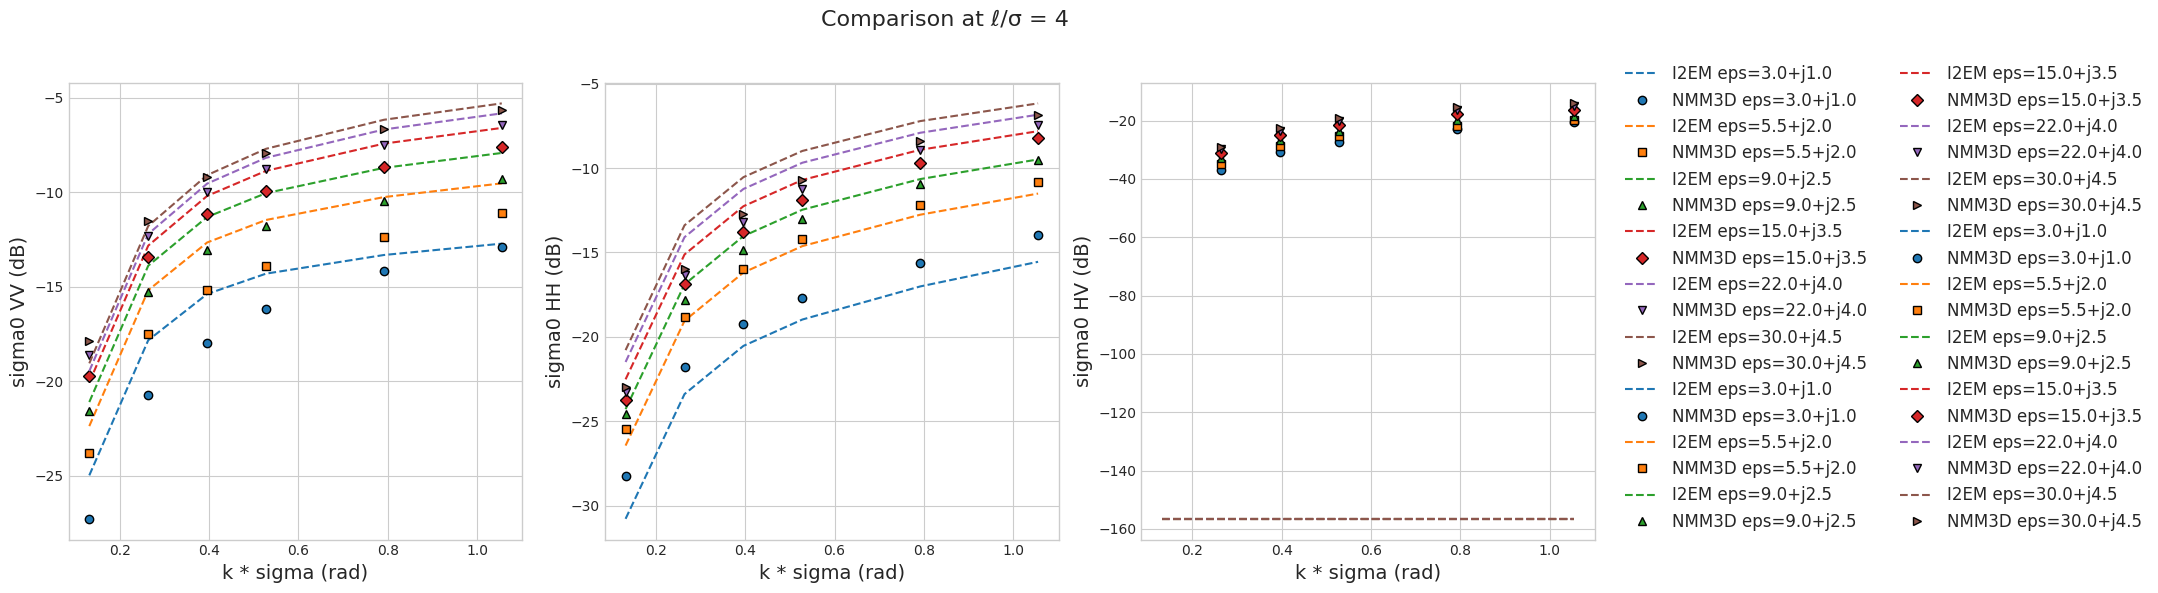

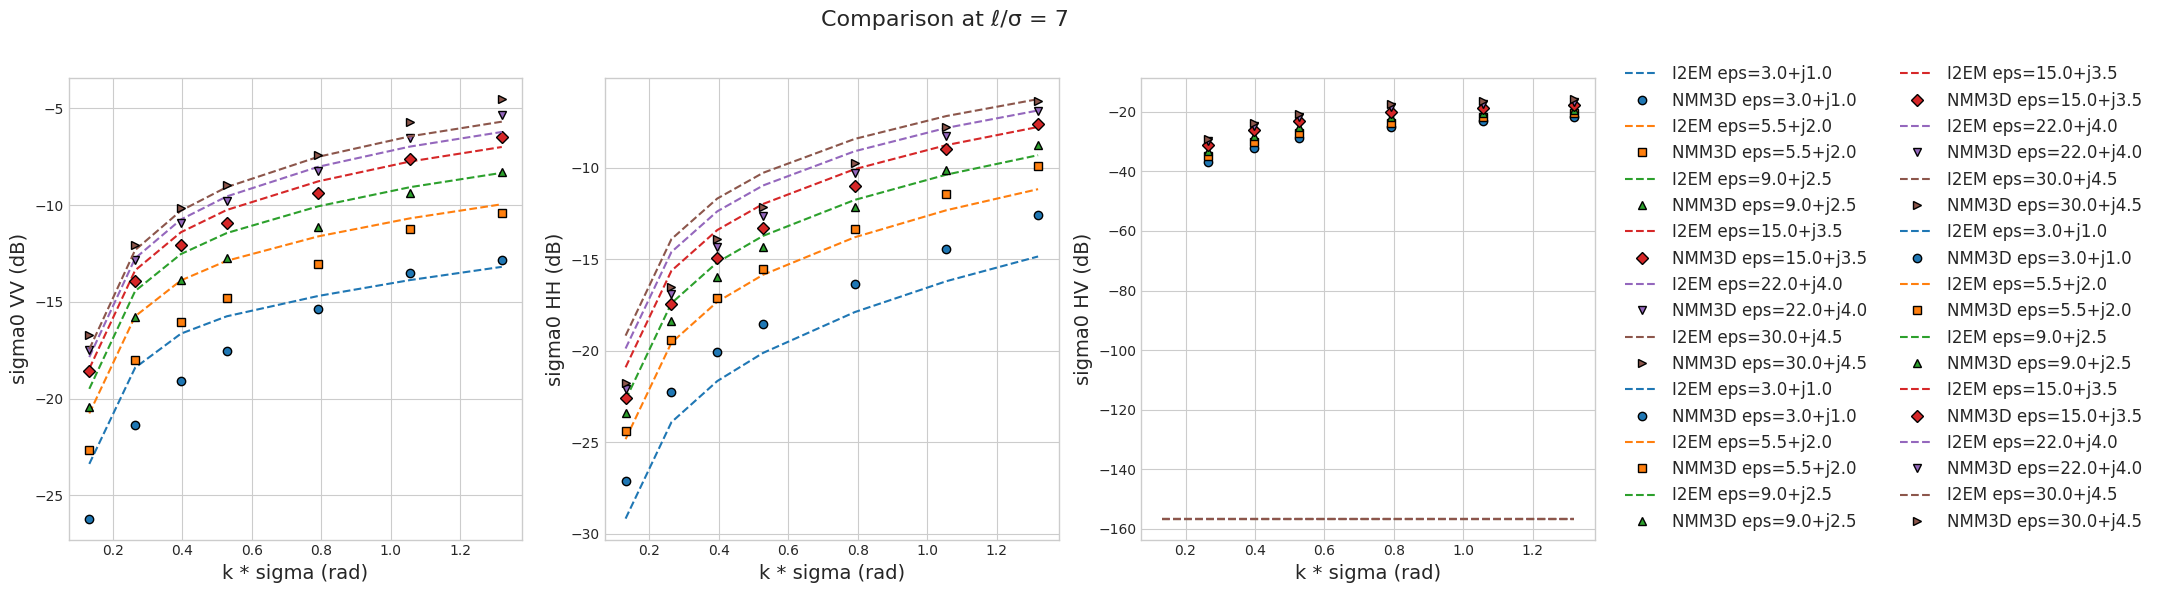

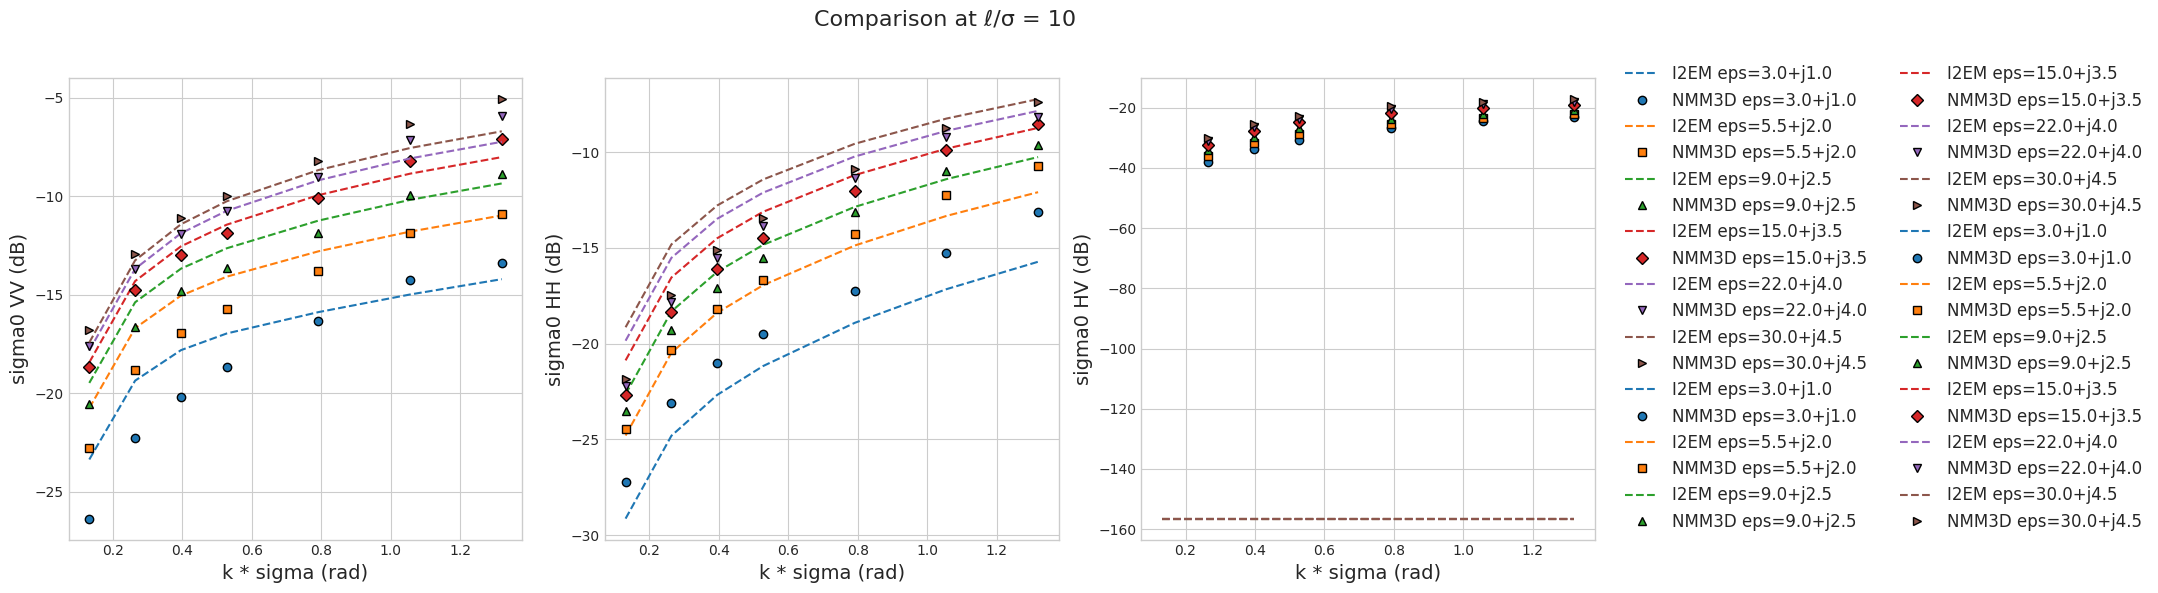

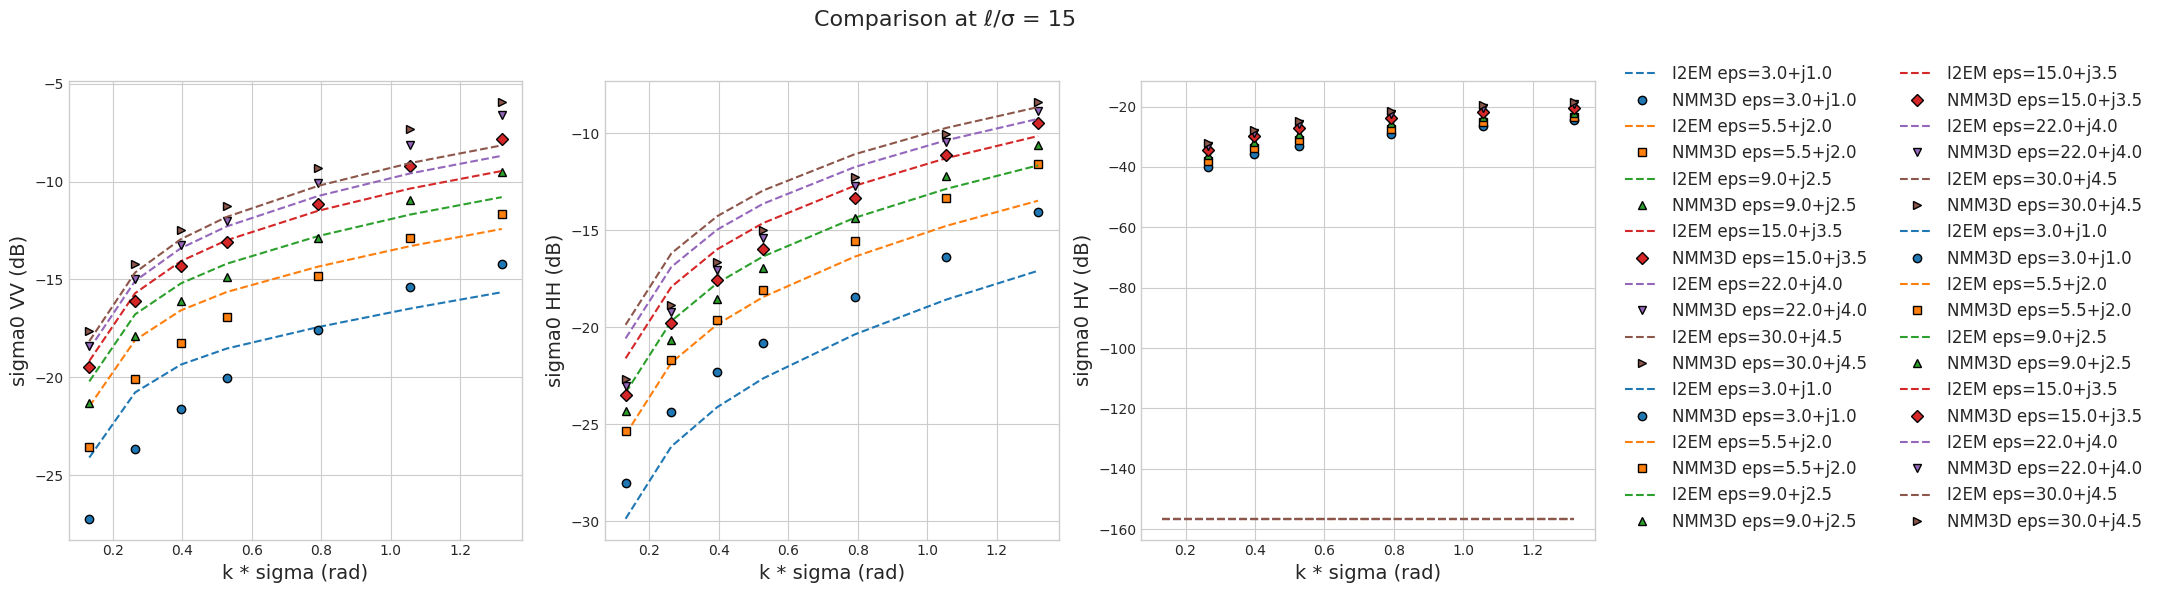

In [6]:
if not group_results:
    raise RuntimeError('No group comparisons available for plotting.')

unique_dielectrics = sorted({(g['eps_real'], g['eps_imag']) for g in group_results})
color_map = {die: plt.cm.tab10(i % 10) for i, die in enumerate(unique_dielectrics)}

ratio_groups = {}
for group in group_results:
    ratio_groups.setdefault(group['ratio'], []).append(group)

for ratio in sorted(ratio_groups):
    groups = ratio_groups[ratio]
    fig, axes = plt.subplots(1, 3, figsize=(19, 6), sharex=True)
    bands = [('vv', 'sigma0 VV (dB)'), ('hh', 'sigma0 HH (dB)'), ('hv', 'sigma0 HV (dB)')]

    handles = []
    labels = []

    for ax, (band_key, ylabel) in zip(axes, bands):
        plotted_labels = set()
        for group in groups:
            eps_pair = (group['eps_real'], group['eps_imag'])
            color = color_map[eps_pair]
            marker = MARKERS[unique_dielectrics.index(eps_pair) % len(MARKERS)]
            ks = group['ks']
            model_vals = group[f'{band_key}_model']
            ref_vals = group[f'{band_key}_ref']

            label_model = f'I2EM eps={eps_pair[0]:.1f}+j{eps_pair[1]:.1f}'
            if label_model not in plotted_labels:
                line, = ax.plot(ks, model_vals, linestyle='--', color=color, label=label_model)
                handles.append(line)
                labels.append(label_model)
                plotted_labels.add(label_model)
            else:
                ax.plot(ks, model_vals, linestyle='--', color=color)

            finite_mask = np.isfinite(ref_vals)
            if np.any(finite_mask):
                label_ref = f'NMM3D eps={eps_pair[0]:.1f}+j{eps_pair[1]:.1f}'
                if label_ref not in plotted_labels:
                    pts = ax.plot(
                        ks[finite_mask],
                        ref_vals[finite_mask],
                        linestyle='none',
                        marker=marker,
                        markersize=6,
                        markerfacecolor=color,
                        markeredgecolor='black',
                        label=label_ref
                    )[0]
                    handles.append(pts)
                    labels.append(label_ref)
                    plotted_labels.add(label_ref)
                else:
                    ax.plot(
                        ks[finite_mask],
                        ref_vals[finite_mask],
                        linestyle='none',
                        marker=marker,
                        markersize=6,
                        markerfacecolor=color,
                        markeredgecolor='black'
                    )

        ax.set_xlabel('k * sigma (rad)', fontsize=14)
        ax.set_ylabel(ylabel, fontsize=14)
        ax.grid(True)

    fig.suptitle(f'Comparison at ℓ/σ = {ratio:g}', fontsize=16)
    if handles:
        fig.legend(handles, labels, bbox_to_anchor=(0.85, 0.5), loc='center left', fontsize=12, ncol=2)
    fig.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.show()


In [7]:
metrics_tables = []
for ratio in sorted(ratio_groups):
    groups = ratio_groups[ratio]
    rows = []
    for band, label in [('vv', 'VV'), ('hh', 'HH'), ('hv', 'HV')]:
        ref_segments = [g[f'{band}_ref'] for g in groups]
        sim_segments = [g[f'{band}_model'] for g in groups]
        if not ref_segments:
            rows.append({'ratio': ratio, 'Band': label, 'Samples': 0, 'RMSE (dB)': np.nan, 'Bias (dB)': np.nan, 'MAE (dB)': np.nan, 'Correlation r': np.nan})
            continue
        ref = np.concatenate(ref_segments)
        sim = np.concatenate(sim_segments)
        stats = compute_metrics(sim, ref)
        rows.append({
            'ratio': ratio,
            'Band': label,
            'Samples': stats['n'],
            'RMSE (dB)': stats['rmse'],
            'Bias (dB)': stats['bias'],
            'MAE (dB)': stats['mae'],
            'Correlation r': stats['r'],
        })
    metrics_tables.append(pd.DataFrame(rows))

if metrics_tables:
    metrics_df = pd.concat(metrics_tables, ignore_index=True).set_index(['ratio', 'Band'])
else:
    metrics_df = pd.DataFrame(columns=['ratio', 'Band', 'Samples', 'RMSE (dB)', 'Bias (dB)', 'MAE (dB)', 'Correlation r']).set_index(['ratio', 'Band'])
metrics_df


Samples   RMSE (dB)   Bias (dB)    MAE (dB)  Correlation r
ratio Band                                                            
4.0   VV         36    1.431512    1.042313    1.188537   9.814945e-01
      HH         36    1.356469    0.461566    1.167248   9.785429e-01
      HV         30  133.096309 -132.958931  132.958931   3.721760e-16
7.0   VV         42    1.185768    0.582114    0.885245   9.861899e-01
      HH         42    1.392219    0.356531    1.166954   9.682816e-01
      HV         36  132.670774 -132.555320  132.555320  -1.872555e-16
10.0  VV         42    1.183007    0.350152    0.892495   9.881316e-01
      HH         42    1.456529    0.345893    1.217606   9.614067e-01
      HV         36  131.194707 -131.081709  131.081709  -3.081703e-16
15.0  VV         42    1.288926    0.041325    1.026768   9.895820e-01
      HH         42    1.545434    0.216319    1.297024   9.524505e-01
      HV         36  129.275694 -129.154764  129.154764  -3.883675e-16

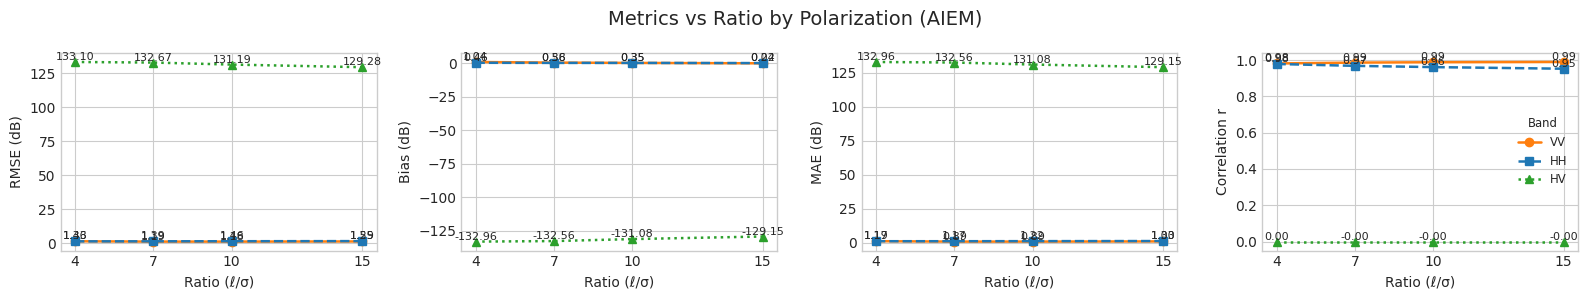

In [8]:
# stacked 4x1 plots: one row per metric, lines for VV/HH/HV across ratios
bands = ['VV', 'HH', 'HV']
metrics = ['RMSE (dB)', 'Bias (dB)', 'MAE (dB)', 'Correlation r']
ratios_plot = np.array(sorted(metrics_df.index.get_level_values(0).unique()))

# simple consistent styles per band
band_styles = {
    'VV': dict(color=plt.cm.tab10(1), linestyle='-', marker='o'),
    'HH': dict(color=plt.cm.tab10(0), linestyle='--', marker='s'),
    'HV': dict(color=plt.cm.tab10(2), linestyle=':', marker='^'),
}

fig, axes = plt.subplots(1, len(metrics), figsize=(16, 3))
fig.suptitle('Metrics vs Ratio by Polarization (AIEM)', fontsize=14)

for i, metric in enumerate(metrics):
    ax = axes[i]
    for band in bands:
        vals = []
        for r in ratios_plot:
            try:
                vals.append(float(metrics_df.loc[(r, band), metric]))
            except Exception:
                vals.append(np.nan)
        vals = np.array(vals, dtype=float)
        style = band_styles[band]
        ax.plot(ratios_plot, vals, label=band,
                color=style['color'], linestyle=style['linestyle'],
                marker=style['marker'], linewidth=1.8, markersize=6)
        # annotate points
        for x, y in zip(ratios_plot, vals):
            if np.isfinite(y):
                ax.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=8)

    ax.set_ylabel(metric, fontsize=10)
    ax.set_xlabel('Ratio (ℓ/σ)')
    ax.set_xticks(ratios_plot)

    if i == 3:
        ax.legend(title='Band', fontsize='small', title_fontsize='small')
        
fig.tight_layout()
plt.show()


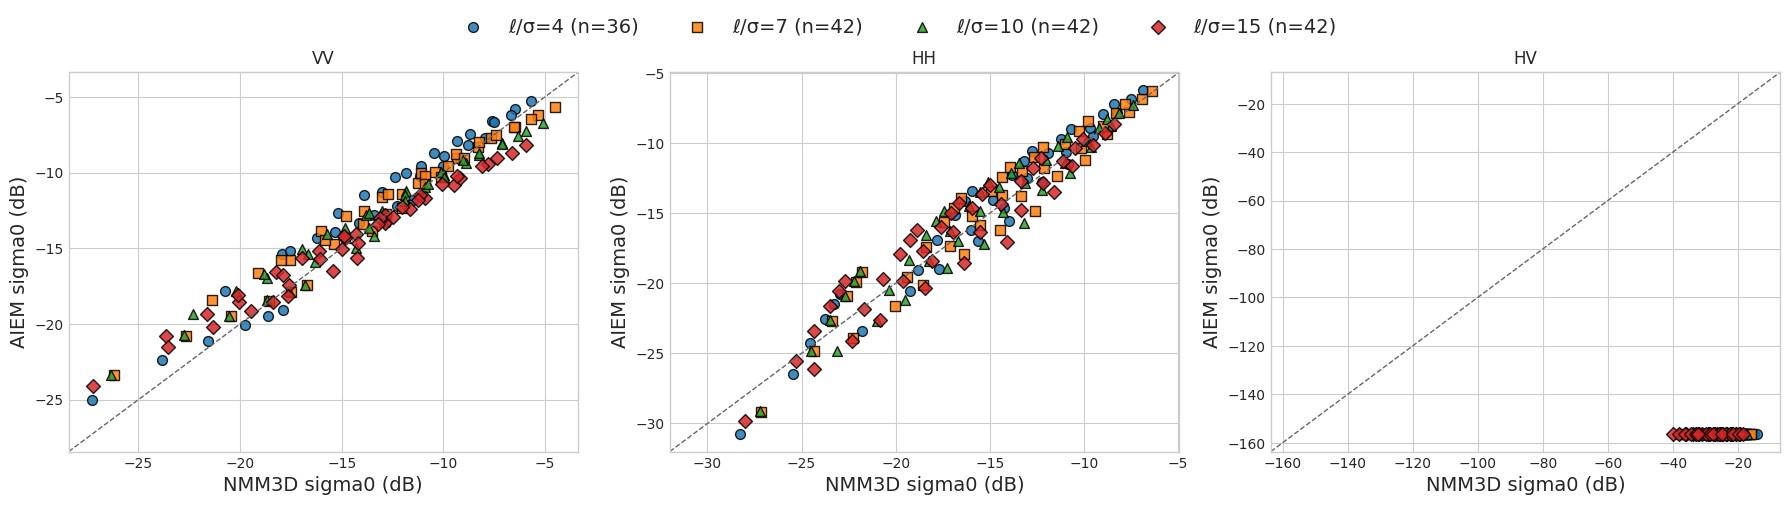

In [9]:
# scatter predicted vs measured per band, with ratios in different colors/styles
ratios = sorted(ratio_groups.keys())
markers = list(MARKERS.values())
colors = [plt.cm.tab10(i % 10) for i in range(len(ratios))]

bands = [('vv', 'VV'), ('hh', 'HH'), ('hv', 'HV')]
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False, sharey=False)

# store axis extents to draw 1:1 line consistently per subplot
extents = {bkey: [np.inf, -np.inf] for bkey, _ in bands}

for i, ratio in enumerate(ratios):
    groups = ratio_groups[ratio]
    marker = markers[i % len(markers)]
    color = colors[i]
    for ax_idx, (bkey, bname) in enumerate(bands):
        ref_segs = [g[f'{bkey}_ref'] for g in groups]
        sim_segs = [g[f'{bkey}_model'] for g in groups]
        if not ref_segs or not sim_segs:
            continue
        ref = np.concatenate(ref_segs)
        sim = np.concatenate(sim_segs)
        mask = np.isfinite(ref) & np.isfinite(sim)
        if not np.any(mask):
            # for HV there may be -inf measured entries; skip those points
            mask = np.isfinite(ref) & np.isfinite(sim)
        if not np.any(mask):
            continue
        ax = axes[ax_idx]
        ax.scatter(ref[mask], sim[mask],
                   label=f'ℓ/σ={ratio:g} (n={mask.sum()})',
                   color=color, marker=marker, edgecolor='black', alpha=0.85, s=50)
        # update extents
        combined_min = min(np.nanmin(ref[mask]), np.nanmin(sim[mask]))
        combined_max = max(np.nanmax(ref[mask]), np.nanmax(sim[mask]))
        extents[bkey][0] = min(extents[bkey][0], combined_min)
        extents[bkey][1] = max(extents[bkey][1], combined_max)

# finalize each subplot: 1:1 line, labels, titles
for ax_idx, (bkey, bname) in enumerate(bands):
    ax = axes[ax_idx]
    lo, hi = extents[bkey]
    if not np.isfinite(lo) or not np.isfinite(hi):
        # fallback to autoscale if nothing plotted
        ax.autoscale()
    else:
        pad = 0.05 * (hi - lo) if hi > lo else 1.0
        ax.set_xlim(lo - pad, hi + pad)
        ax.set_ylim(lo - pad, hi + pad)
        ax.plot([lo - pad, hi + pad], [lo - pad, hi + pad], color='0.4', linestyle='--', linewidth=1)
    ax.set_xlabel('NMM3D sigma0 (dB)', fontsize=14)
    ax.set_ylabel('AIEM sigma0 (dB)', fontsize=14)
    ax.set_title(f'{bname}')
    ax.grid(True)

# shared legend (ratios)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=min(len(ratios), 6), bbox_to_anchor=(0.5, 1.02), fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
